In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import sys
import warnings
from scipy.stats import entropy, pearsonr, ttest_rel
warnings.filterwarnings("ignore")

In [2]:
###
methods = ['stsc', 'spatialDWLS', 'RCTD', 'cell2loc', 'music', 'spotlight']

#folder = '/mnt/humble_50t/alexw/ReSort_manuscript/simulation/simulation_finer_resolution/results/'
# tru_fn = "/mnt/humble_50t/alexw/ReSort_manuscript/simulation/simulation_finer_resolution/data/cancer_inf_0.1/simulated_mixture_cell_ground_truth.csv"
folder = '../../models_results/secondary_results/'
tru_fn = '../../simulated_data/infiltrated/simulated_mixture_cell_ground_truth_secondary.csv'
truth = pd.read_csv(tru_fn, index_col=0)
truth = truth[['Cancer', 'Ductal', 'count_Macrophages', 'count_Mast', 'count_mDCs', 'count_Monocytes']]
truth.columns = ['Cancer', 'Ductal', 'Macrophages', 'Mast', 'mDCs', 'Monocytes']
truth = truth.divide(truth.sum(axis=1), axis=0)

In [3]:
def read_process_res(fp, method,
                     cell_types=['Cancer', 'Ductal', 'mDCs', 'Monocytes', 'Mast', 'Macrophages']):
    
    if method == 'stsc':
        sep = "\t"
    else:
        sep = ","
        
    df = pd.read_csv(fp, sep=sep, index_col=0)

    if method == 'spatialDWLS':
        df.set_index('cell_ID', drop=True, inplace=True)
        df.index.name = None
        
    df = df[cell_types]
    
    for i in range(df.shape[0]):
        if (df.iloc[i, :] == 0).all():
            df.iloc[i, :] = 0.1
            
    df = df.divide(df.sum(axis=1), axis=0)
    return df

def read_2steps(f, method, mode='corrected', fmt='csv'):
    
    sep = ","
    if fmt == 'tsv':
        sep = "\t"
        
    df_mist = pd.read_csv(f"{f}/props_mist.{fmt}", sep=sep, index_col=0)

    if mode == 'corrected':
        df2 = pd.read_csv(f"{f}/props_immune_corrected.{fmt}",sep=sep, index_col=0)
    else:
        df2 = pd.read_csv(f"{f}/props_immune.{fmt}",sep=sep, index_col=0)
        
    if method == 'spatialDWLS':
        df_mist.set_index("cell_ID", drop=True, inplace=True)
        df2.set_index("cell_ID", drop=True, inplace=True)
    df2 = df2[['mDCs', 'Monocytes', 'Mast', 'Macrophages']]
    df2 = df2.divide(df2.sum(axis=1), axis=0)
    
    df_mist = df_mist[['Cancer', 'Ductal', 'Stroma']]
    df_mist = df_mist.divide(df_mist.sum(axis=1), axis=0)
    
    stroma = df_mist['Stroma'].to_numpy()
    
    for c in df2.columns:
        df2[c] = df2[c] * stroma
        
    df2 = pd.concat([df_mist[['Cancer', 'Ductal']], df2], axis=1)
    df2.index.name=None
    return df2

def evaluate_performance(est, tru, 
                      cell_types=['Cancer', 'Ductal', 'mDCs', 'Monocytes', 'Mast', 'Macrophages']):
    """calculate cell type level Mean Absolute Percentage Error"""
    est = est.loc[tru.index, cell_types]
    tru = tru.loc[:, cell_types]
    mae = np.nanmean(np.absolute(est.values - tru.values))
    rs, kls = [], []
    for i in range(est.shape[0]):
        try:
            rs.append(pearsonr(est.values[i], tru.values[i])[0])
        except:
            rs.append(np.nan)
        kl = entropy(est.values[i]+ 0.001, tru.values[i]+ 0.001)
        kls.append(kl)
    ks_df = pd.DataFrame({'KL': kls}, index = tru.index)
    rs_df = pd.DataFrame({'r': rs}, index = tru.index)
    return rs_df, ks_df

def get_results(method, cell_types=['Cancer', 'Ductal', 'mDCs', 'Monocytes', 'Mast', 'Macrophages']):
    
    if method == 'stsc':
        fmt = "tsv"
    else:
        fmt = "csv"
        
    f = f"{folder}{method}"
    
    kls_dfs = []
    
    # internal
    df_int = read_process_res(f"{f}/props_internal.{fmt}", method)
    rs_int, kl_int = evaluate_performance(df_int, truth)
    rs_int['reference'] = 'Internal'
    kl_int['reference'] = 'Internal'
    
    # external
    df_ext = read_process_res(f"{f}/props_external.{fmt}", method)
    rs_ext, kl_ext = evaluate_performance(df_ext, truth)
    rs_ext['reference'] = 'External'
    kl_ext['reference'] = 'External'
    # try:
    #     # our approach
    #     df_corr = read_process_res(f"{f}/props_all_corrected.{fmt}",  method)
    #     mae_corr, r_corr = evaluate_performance(df_corr, truth)
    # except:
    #     mae_corr, r_corr = np.nan, np.nan
    
    # 2step
    df_2step = read_2steps(f, method, '', fmt)
    rs_2step, kl_2step = evaluate_performance(df_2step, truth)
    rs_2step['reference'] = 'ReSort'
    kl_2step['reference'] = 'ReSort'
    
    # # 2step corrected
    # df_2step_corr = read_2steps(f, method, 'corrected', fmt)
    # mae_2step_corr, r_2step_corr = evaluate_performance(df_2step_corr, truth)
    rs_dfs = pd.concat([rs_int, rs_ext, rs_2step])
    kl_dfs = pd.concat([kl_int, kl_ext, kl_2step])
    rs_dfs['method'] = method
    kl_dfs['method'] = method
    return rs_dfs, kl_dfs
    #return {'r': [r_int, r_ext, r_corr, r_2step, r_2step_corr], 'mae': [mae_int, mae_ext, mae_corr, mae_2step, mae_2step_corr]}


# for c in df2step.columns:
#     print(c, np.mean(df2step[c]))

In [4]:
methods = ['stsc', 'spatialDWLS', 'RCTD','cell2loc', 'music', 'spotlight']

r_dfs, kl_dfs = [], []

for method in methods:
    # res = get_results(method)
    # r_df.loc[method, :] = res['r']
    # mae_df.loc[method, :] = res['mae']
    # print(method)
    r_df, kl_df = get_results(method)
    r_dfs.append(r_df)
    kl_dfs.append(kl_df)
r_dfs = pd.concat(r_dfs)
kl_dfs = pd.concat(kl_dfs)
    
# r_df = r_df[['Internal', 'External', 'Correctoin', '2-step', '2-step correction']]
# mae_df = mae_df[['Internal', 'External', 'Correctoin', '2-step', '2-step correction']]

In [5]:
# r_dfs.to_csv("secondary_pearson_spots.csv")
# kl_dfs.to_csv("secondary_kldivergene_spots.csv")

In [6]:
# writer = pd.ExcelWriter('SourceData-Figure3a-d.xlsx', engine='xlsxwriter')

# # Write each dataframe to a different worksheet.
# r_dfs.to_excel(writer, sheet_name='Fig3. a&c')
# kl_dfs.to_excel(writer, sheet_name='Fig3. b&d')

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

In [7]:
internal_r = r_dfs.loc[r_dfs.reference == 'Internal']
external_r = r_dfs.loc[r_dfs.reference == 'External']
mist_r = r_dfs.loc[r_dfs.reference == 'ReSort']
internal_r.index = [f"{internal_r.index.tolist()[i]}_{internal_r.method.tolist()[i]}" for i in range(internal_r.shape[0])]
external_r.index = [f"{external_r.index.tolist()[i]}_{external_r.method.tolist()[i]}" for i in range(external_r.shape[0])]
mist_r.index = [f"{mist_r.index.tolist()[i]}_{mist_r.method.tolist()[i]}" for i in range(mist_r.shape[0])]
external_r = external_r.loc[internal_r.index]
mist_r = mist_r.loc[internal_r.index]
print(ttest_rel(internal_r.r.to_numpy(), mist_r.r.to_numpy(), nan_policy='omit'),
       np.nanmean(internal_r.r.to_numpy() - mist_r.r.to_numpy()),
      np.nanmean(np.absolute(internal_r.r.to_numpy() - mist_r.r.to_numpy())) / np.nanmean(internal_r.r.to_numpy()))

print(ttest_rel(external_r.r.to_numpy(), mist_r.r.to_numpy(), nan_policy='omit'),
      np.nanmean(external_r.r.to_numpy() - mist_r.r.to_numpy()),
      np.nanmean(np.absolute((external_r.r.to_numpy() - mist_r.r.to_numpy())) / np.nanmean(external_r.r.to_numpy())))

Ttest_relResult(statistic=52.27827850867156, pvalue=0.0) 0.09463539181261135 0.1351754928168469
Ttest_relResult(statistic=-44.042619341669685, pvalue=0.0) -0.073527034723401 0.17922904458848943


In [8]:
internal_kl = kl_dfs.loc[kl_dfs.reference == 'Internal']
external_kl = kl_dfs.loc[kl_dfs.reference == 'External']
mist_kl = kl_dfs.loc[kl_dfs.reference == 'ReSort']

internal_kl.index = [f"{internal_kl.index.tolist()[i]}_{internal_kl.method.tolist()[i]}" for i in range(internal_kl.shape[0])]
external_kl.index = [f"{external_kl.index.tolist()[i]}_{external_kl.method.tolist()[i]}" for i in range(external_kl.shape[0])]
mist_kl.index = [f"{mist_kl.index.tolist()[i]}_{mist_kl.method.tolist()[i]}" for i in range(mist_kl.shape[0])]
external_kl = external_kl.loc[internal_kl.index]
mist_kl = mist_kl.loc[internal_kl.index]

print(ttest_rel(internal_kl.KL.to_numpy(), mist_kl.KL.to_numpy(), nan_policy='omit'),
      np.nanmean(np.absolute((internal_kl.KL.to_numpy() - mist_kl.KL.to_numpy()))),
      np.nanmean(np.absolute((internal_kl.KL.to_numpy() - mist_kl.KL.to_numpy()))) / np.nanmean(internal_kl.KL.to_numpy()))

print(ttest_rel(external_kl.KL.to_numpy(), mist_kl.KL.to_numpy(), nan_policy='omit'),
       np.nanmean(external_kl.KL.to_numpy() - mist_kl.KL.to_numpy()),
      np.nanmean(np.absolute((external_kl.KL.to_numpy() - mist_kl.KL.to_numpy())))/ np.nanmean(external_kl.KL.to_numpy()))

Ttest_relResult(statistic=-36.54852092348903, pvalue=3.0941255591862e-280) 0.2912847672461767 0.9963522784237225
Ttest_relResult(statistic=62.4306490648725, pvalue=0.0) 0.3589343060622437 0.6559752478247003


In [9]:
xorder = ['stsc','spatialDWLS','RCTD','cell2loc','music','spotlight']

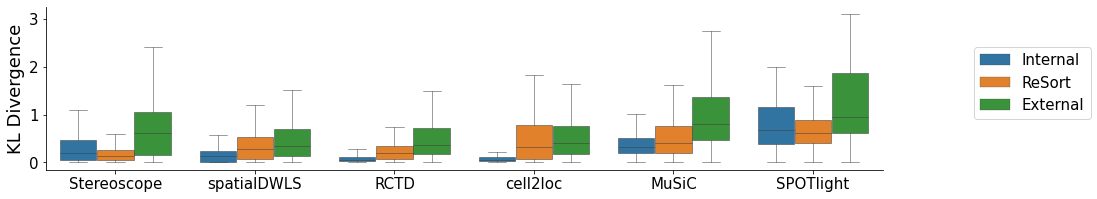

In [10]:
f = plt.figure(figsize=(15, 3))
sns.boxplot(data=kl_dfs, x='method', y='KL', hue='reference', 
            order = xorder,
            hue_order = ['Internal', 'ReSort', 'External'],
              linewidth=0.5, showfliers=False)
sns.despine();
plt.xticks(range(6), ['Stereoscope', 'spatialDWLS', 'RCTD', 'cell2loc', 'MuSiC', 'SPOTlight'],
          fontsize=15);
plt.xlabel("")
plt.tick_params(axis='y', labelsize=15)
plt.ylabel("KL Divergence", fontsize=18)
plt.legend(fontsize=15, bbox_to_anchor=(1.1, 0.8));
#plt.savefig('Fig3-secondary_KL_diver_boxplot.png', dpi=200, bbox_inches='tight')

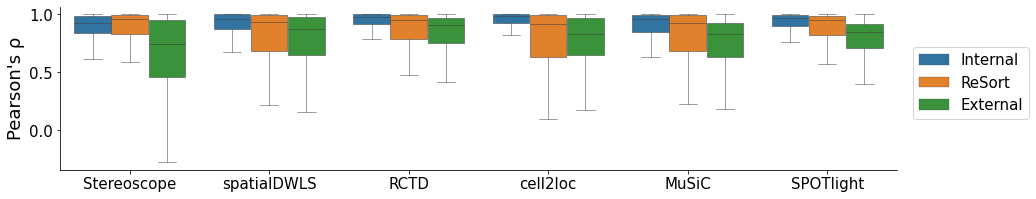

In [11]:
f = plt.figure(figsize=(15, 3))
sns.boxplot(data=r_dfs, x='method', y='r', hue='reference', showfliers=False,
            order = xorder,
            hue_order = ['Internal', 'ReSort', 'External'],
              linewidth=0.5);
sns.despine();

plt.xticks(range(6), ['Stereoscope', 'spatialDWLS', 'RCTD','cell2loc', 'MuSiC', 'SPOTlight'],
          fontsize=15);

plt.xlabel("")
plt.tick_params(axis='y', labelsize=15)
plt.ylabel("Pearson's \u03C1", fontsize=18)
plt.legend(fontsize=15,bbox_to_anchor=(1.01, 0.8));
#plt.savefig('Fig3-secondary_Pearson_boxplot.png', dpi=200, bbox_inches='tight')

Text(33.0, 0.5, "Pearson's $\\rho$")

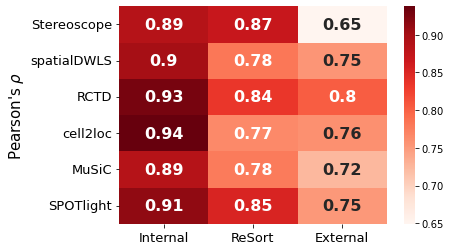

In [12]:
r_mean_df = pd.pivot_table(data=r_dfs, index='method', columns='reference', values='r', aggfunc='mean')
r_mean_df.index.name=None
r_mean_df.columns.name=None

r_mean_df = r_mean_df.loc[['stsc', 'spatialDWLS', 'RCTD', 'cell2loc', 'music', 'spotlight'],
                          ['Internal','ReSort', 'External']]

f, ax = plt.subplots(1,1)

sns.heatmap(data=r_mean_df, annot=True, annot_kws={'weight':'bold', 'size':'16'}, cmap='Reds')
ax.set_yticklabels(['Stereoscope', 'spatialDWLS', 'RCTD', 'cell2loc', 'MuSiC', 'SPOTlight']);
ax.set_xticklabels(['Internal', 'ReSort', 'External']);
ax.set_xlabel("")
ax.tick_params(axis='both', labelsize=13)
ax.set_ylabel(r"Pearson's $\rho$", fontsize=15)
#plt.savefig('Fig3-secondary_Mean_Pearson_r_heatmap.png', dpi=200, bbox_inches='tight')

In [13]:
r_mean_df

,Internal,ReSort,External
stsc,0.885865,0.869558,0.649322
spatialDWLS,0.900464,0.782018,0.754853
RCTD,0.928494,0.835025,0.802726
cell2loc,0.937659,0.766046,0.758720
music,0.886119,0.778363,0.724504
spotlight,0.912900,0.852678,0.752402


Text(33.0, 0.5, 'KL Divergence')

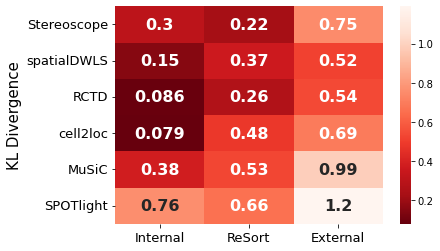

In [14]:
kl_mean_df = pd.pivot_table(data=kl_dfs, index='method', columns='reference', values='KL', aggfunc='mean')
kl_mean_df.index.name=None
kl_mean_df.columns.name=None
kl_mean_df = kl_mean_df.loc[['stsc', 'spatialDWLS', 'RCTD', 'cell2loc', 'music', 'spotlight'],
                          ['Internal', 'ReSort','External']]

f, ax = plt.subplots(1,1)

sns.heatmap(data=kl_mean_df, annot=True, annot_kws={'weight':'bold', 'size':'16'}, cmap='Reds_r')
ax.set_yticklabels(['Stereoscope', 'spatialDWLS', 'RCTD', 'cell2loc', 'MuSiC', 'SPOTlight'],
          fontsize=15);
ax.set_xticklabels(['Internal', 'ReSort', 'External'],
          fontsize=13);
ax.set_xlabel("")
ax.tick_params(axis='y', labelsize=13)
ax.set_ylabel("KL Divergence", fontsize=15)
#plt.savefig('Fig3-secondary_Mean_KL_diver_heatmap.png', dpi=200, bbox_inches='tight')

In [20]:
# f = plt.figure(figsize=(8,6))
# sns.heatmap(r_df.round(2), annot=True, 
#             annot_kws={'fontsize': 15, 'fontweight': 'bold'}, cmap='Reds')
# plt.tick_params(axis='both', labelsize=15)
# plt.tick_params(axis='y', rotation=0)
# plt.tick_params(axis='x', rotation=45)